In [13]:
import math
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss

In [14]:
def time_series_train_test(X, y, test_size=0.25):
    x_size = len(X)
    if x_size != len(y):
        raise ValueError
    split_index = int(x_size * (1 -test_size))
    if (x_size % 2) == 1:
        split_index += 1
    X_train = X.iloc[:split_index]
    y_train = y.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_test = y.iloc[split_index:]
    return (X_train, y_train, X_test, y_test)

In [15]:
def fit_model(X, y, model, test_size=0.25):
    X_train, y_train, X_test, y_test = time_series_train_test(X, y, test_size=test_size)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print(f"Точность на обучающей выборке(R^2): {round(model.score(X_train, y_train), 3)}")
    print(f"Точность на тестовой выборке(R^2): {round(model.score(X_test, y_test), 3)}")
    print(f"MSE: {round(mse, 2)}")
    print(f"RMSE: {round(math.sqrt(mse), 3)}")
    plt.figure(figsize=(15, 7))
    plt.plot(range(len(y_test.values)), y_test.values, label='test data')
    plt.plot(range(len(pred)), pred, 'r--', label='prediction')
    plt.legend(loc=(1.01, 0))
    plt.title("Точность на тестовой выборке")
    plt.show()

In [16]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


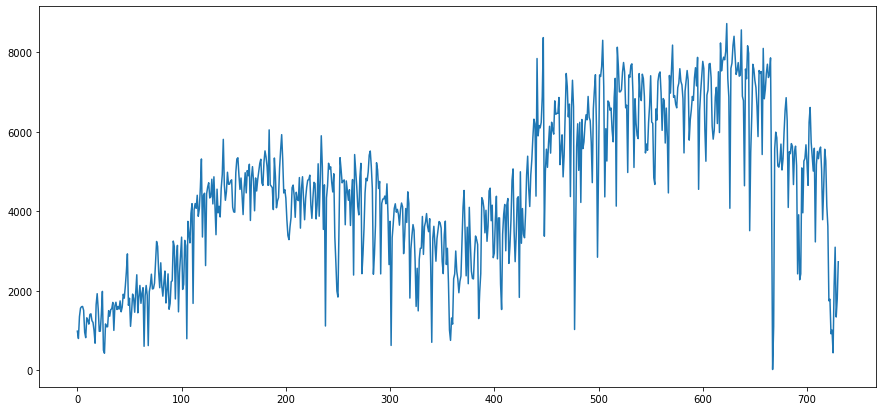

In [17]:
plt.figure(figsize=(15, 7))
plt.plot(range(len(df['cnt'].values)), df['cnt'].values, label='test data')
plt.show()

In [18]:
df = pd.get_dummies(df, columns=['weathersit', 'season', 'yr', 'holiday', 'weekday'])

In [19]:
df['dteday'] = pd.to_datetime(df['dteday'])

In [20]:
df['day'] = df['dteday'].dt.day

In [21]:
series_target_total = 'cnt'
series_target_casual = 'casual'
series_target_registered = 'registered'

## Первичная модель без метеоданных

Точность на обучающей выборке(R^2): 0.833
Точность на тестовой выборке(R^2): 0.634
MSE: 171889.07
RMSE: 414.595


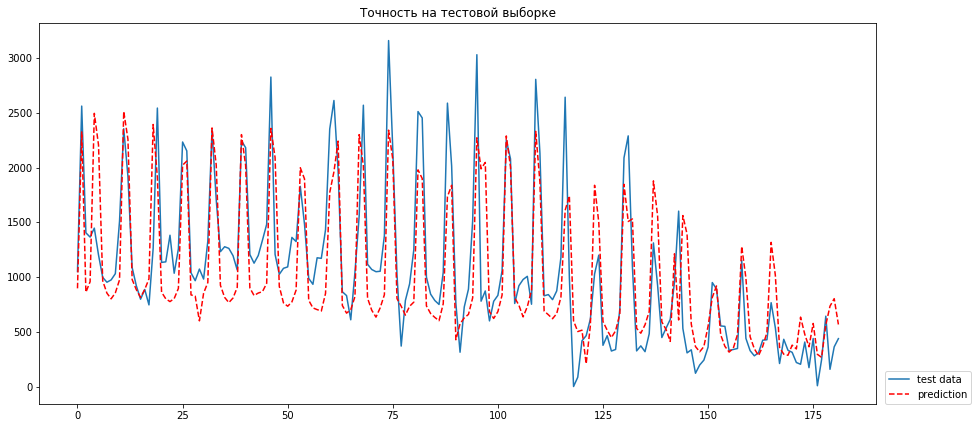

In [22]:
features = [
       'mnth', 'workingday', 'season_1', 'season_2', 'season_3',
       'season_4', 'yr_0', 'yr_1', 'holiday_0', 'holiday_1', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'day'
]
series_gb = GradientBoostingRegressor(random_state=0)
fit_model(df[features], df[series_target_casual], series_gb)

In [23]:
df.columns

Index(['instant', 'dteday', 'mnth', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'season_1', 'season_2', 'season_3',
       'season_4', 'yr_0', 'yr_1', 'holiday_0', 'holiday_1', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'day'],
      dtype='object')

# Прогнозирование временного ряда

In [24]:
series_features = [
'mnth', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'season_1', 'season_2', 'season_3',
       'season_4', 'yr_0', 'yr_1', 'holiday_0', 'holiday_1', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'day'
]

## Использование метеоданных, градиентный бустинг с параметрами по умолчанию

Точность на обучающей выборке(R^2): 0.951
Точность на тестовой выборке(R^2): 0.797
MSE: 95632.81
RMSE: 309.246


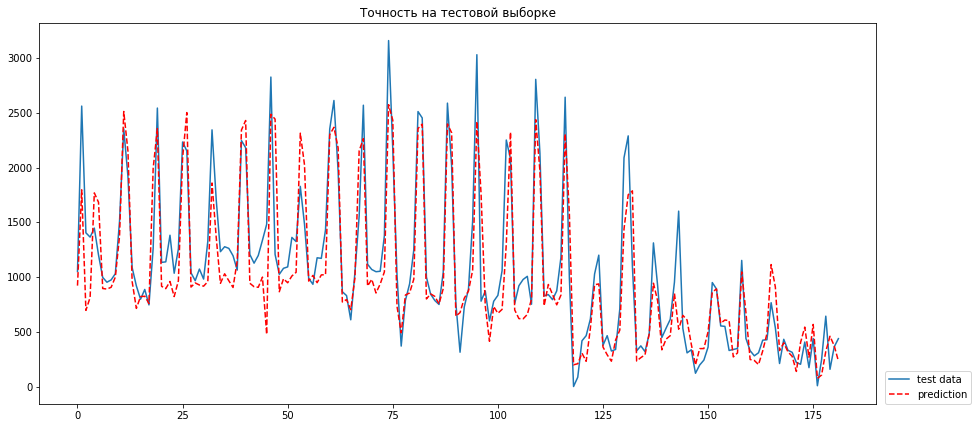

In [26]:
simple_gd = GradientBoostingRegressor(random_state=0)
fit_model(df[series_features], df[series_target_casual], simple_gd)

## Использование метеоданных, градиентный бустинг после тюнинга

Точность на обучающей выборке(R^2): 0.974
Точность на тестовой выборке(R^2): 0.855
MSE: 68248.9
RMSE: 261.245


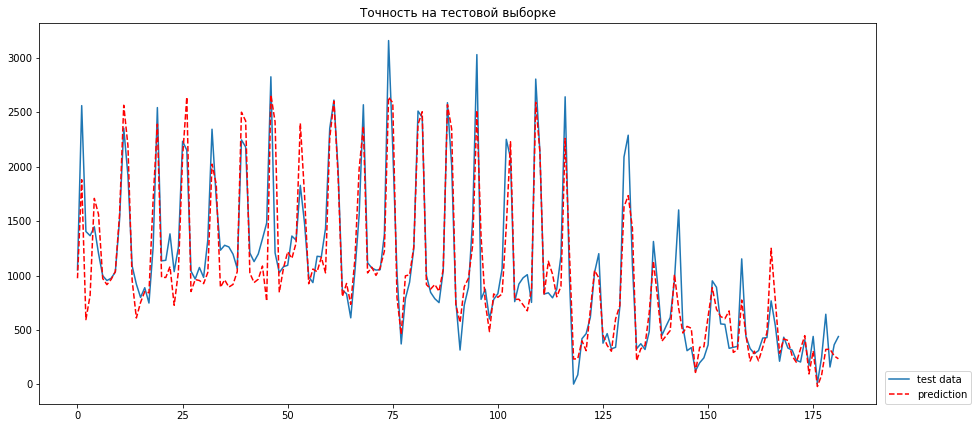

In [90]:
series_gb = GradientBoostingRegressor(random_state=0, n_estimators=520, subsample=0.45, learning_rate=0.05, max_leaf_nodes=5, max_depth=4)
fit_model(df[series_features], df[series_target_casual], series_gb)